In [1]:
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings("ignore")

In [2]:
df = dd.read_csv("archive/For_modeling.csv")

In [3]:
df = df.drop("Unnamed: 0",axis=1)

In [4]:
df.head()

,Duration,Distance,PLong,PLatd,DLong,DLatd,Haversine,Pmonth,Pday,Phour,...,Dmin,DDweek,Temp,Precip,Wind,Humid,Solar,Snow,GroundTemp,Dust
0,3,50,37.544666,126.888359,37.544666,126.888359,0.000000,1,1,0,...,4,0,-3.2,0.0,0.5,40.0,0.0,0.0,-2.2,25.0
1,24,7670,37.506199,127.003944,37.551250,127.035103,5.713529,1,1,0,...,25,0,-3.2,0.0,0.5,40.0,0.0,0.0,-2.2,25.0
2,8,1390,37.544590,127.057083,37.537014,127.061096,0.913702,1,1,0,...,9,0,-3.2,0.0,0.5,40.0,0.0,0.0,-2.2,25.0
3,8,1820,37.571102,127.023560,37.561447,127.034920,1.468027,1,1,0,...,10,0,-3.2,0.0,0.5,40.0,0.0,0.0,-2.2,25.0
4,4,850,37.573242,127.015907,37.565849,127.016403,0.823227,1,1,0,...,6,0,-3.2,0.0,0.5,40.0,0.0,0.0,-2.2,25.0


This data contains Seoul Bike data and weather data. In other words combining of bike and
weather data

In [5]:
df.columns

Index(['Duration', 'Distance', 'PLong', 'PLatd', 'DLong', 'DLatd', 'Haversine',
       'Pmonth', 'Pday', 'Phour', 'Pmin', 'PDweek', 'Dmonth', 'Dday', 'Dhour',
       'Dmin', 'DDweek', 'Temp', 'Precip', 'Wind', 'Humid', 'Solar', 'Snow',
       'GroundTemp', 'Dust'],
      dtype='object')

In [6]:
# There is no null values

df.isna().sum().any().compute()

False

In [7]:
# To avoid oversubscribing threads. 
# To divide all processes to one core.

!export OMP_NUM_THREADS=1
!export MKL_NUM_THREADS=1
!export OPENBLAS_NUM_THREADS=1

Testing if dask array could be faster for mean process than dataframe but they took same time.

In [8]:
%%timeit 
df["Duration"].mean().compute()

5.43 s ± 99.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%%timeit
new_arr = da.from_array(df["Duration"].compute().values,\
                    chunks=(1000000,))
new_arr.mean().compute()

5.39 s ± 44.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Get the shape of dask dataframe.

In [10]:
def get_df_shape(df=None):
    print(f"({df.shape[0].compute()},{df.shape[1]})")
    
get_df_shape(df)

(9601139,25)


In [11]:
df.dtypes

Duration        int64
Distance        int64
PLong         float64
PLatd         float64
DLong         float64
DLatd         float64
Haversine     float64
Pmonth          int64
Pday            int64
Phour           int64
Pmin            int64
PDweek          int64
Dmonth          int64
Dday            int64
Dhour           int64
Dmin            int64
DDweek          int64
Temp          float64
Precip        float64
Wind          float64
Humid         float64
Solar         float64
Snow          float64
GroundTemp    float64
Dust          float64
dtype: object

Dask doesn't get all data because of that you can not select rows using iloc. So because of that we create a new column named index with unique numbers. So by this way we can select rows too. Create a pandas dataframe after that add a new column that contains unique numbers. After that query. 

In [12]:
df_2 = df.compute()

In [13]:
df_2["index"] = list(range(0, len(df)))

In [14]:
df_2 = dd.from_pandas(df_2,npartitions=2)

Slicing. Using range and changing it you can select rows.

In [15]:
df_2[df_2["index"].isin(range(8,15))][["Duration","Distance"]].compute()

,Duration,Distance
8,3,950
9,25,3900
10,27,4750
11,23,4820
12,16,2930
13,30,5140
14,11,1800


In [16]:
df_2[df_2["index"].isin(range(8,15))].iloc[:,:10].compute()

,Duration,Distance,PLong,PLatd,DLong,DLatd,Haversine,Pmonth,Pday,Phour
8,3,950,37.459953,127.024742,37.455799,127.016289,0.877524,1,1,0
9,25,3900,37.527122,127.028717,37.539654,127.052589,2.524430,1,1,0
10,27,4750,37.570721,126.898979,37.578072,126.930817,2.922488,1,1,0
11,23,4820,37.570721,126.898979,37.578072,126.930817,2.922488,1,1,0
12,16,2930,37.599491,126.916862,37.620949,126.925636,2.508075,1,1,0
13,30,5140,37.512169,127.078934,37.483311,127.084938,3.252289,1,1,0
14,11,1800,37.525650,126.887817,37.535961,126.898300,1.472768,1,1,0


In [17]:
df_2[df_2["index"].isin(range(8,15))].iloc[:,10:20].compute()

,Pmin,PDweek,Dmonth,Dday,Dhour,Dmin,DDweek,Temp,Precip,Wind
8,2,0,1,1,0,5,0,-3.2,0.0,0.5
9,2,0,1,1,0,28,0,-3.2,0.0,0.5
10,2,0,1,1,0,30,0,-3.2,0.0,0.5
11,3,0,1,1,0,30,0,-3.2,0.0,0.5
12,3,0,1,1,0,20,0,-3.2,0.0,0.5
13,5,0,1,1,0,36,0,-3.2,0.0,0.5
14,5,0,1,1,0,17,0,-3.2,0.0,0.5


In [18]:
df_2[df_2["index"].isin(range(8,15))].iloc[:,20:].compute()

,Humid,Solar,Snow,GroundTemp,Dust,index
8,40.0,0.0,0.0,-2.2,25.0,8
9,40.0,0.0,0.0,-2.2,25.0,9
10,40.0,0.0,0.0,-2.2,25.0,10
11,40.0,0.0,0.0,-2.2,25.0,11
12,40.0,0.0,0.0,-2.2,25.0,12
13,40.0,0.0,0.0,-2.2,25.0,13
14,40.0,0.0,0.0,-2.2,25.0,14


Unique months.

In [19]:
sorted(df_2["Pmonth"].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

Summations of distances' depending on months. Longest trip duration time on 9th and 10th months.

In [20]:
pmonth_duration = df_2.groupby("Pmonth").sum()["Duration"].compute()

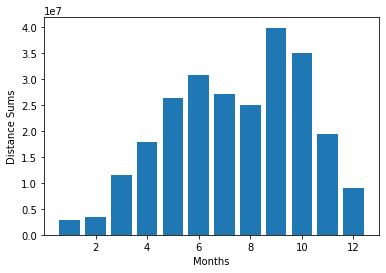

In [21]:
plt.bar(pmonth_duration.keys(), pmonth_duration)
plt.xlabel("Months")
plt.ylabel("Distance Sums")
plt.show()

Use dask array to compute Normalization. Normalize all the columns.

In [22]:
arr = da.from_array(df_2["Duration"].compute().values,chunks=(1000000,))

In [23]:
%time arr.min().compute()

CPU times: user 34.6 ms, sys: 0 ns, total: 34.6 ms
Wall time: 7.35 ms


1

In [24]:
%time min(arr.compute())

CPU times: user 607 ms, sys: 7.92 ms, total: 615 ms
Wall time: 617 ms


1

In [ ]:
# Normalizing columns to [0-1] range.

for col in df_2.columns:
    if col=="index":
        pass
    else:
        arr = da.from_array(df_2[col].compute().values,chunks=(1000000,))
        min_arr = arr.min()
        max_arr = arr.max()
        normalized_arr = (arr-min_arr)/(max_arr-min_arr)
        normalized_arr = normalized_arr.compute()
        col_name = "{}_n".format(col)
        df_2[f"{col_name}"] = dd.from_array(normalized_arr)

Plot boxplot of all columns'.

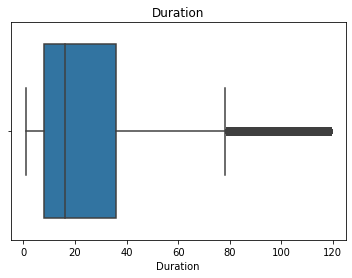

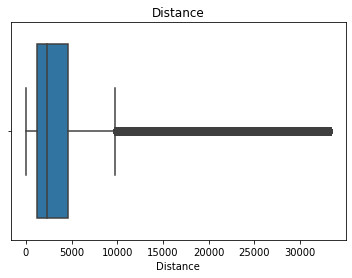

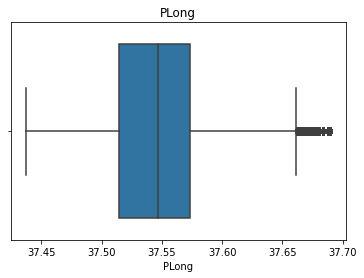

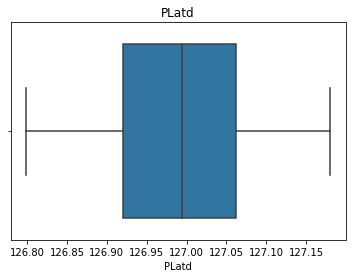

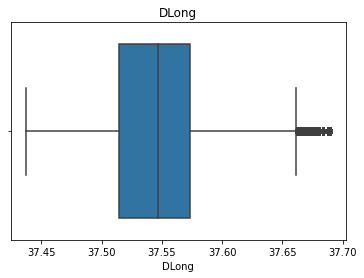

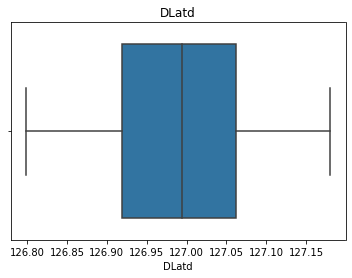

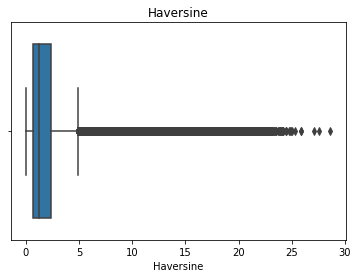

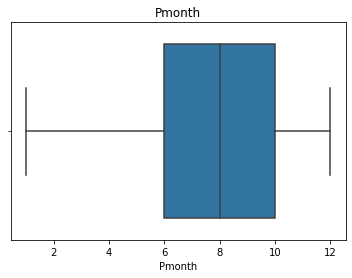

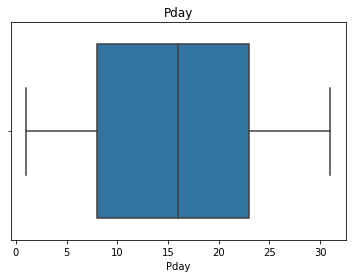

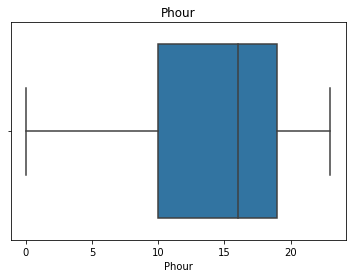

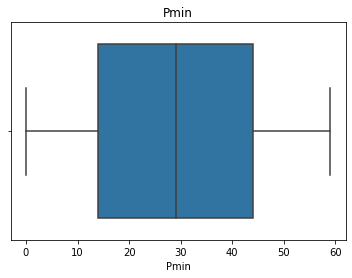

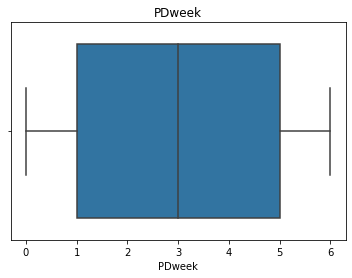

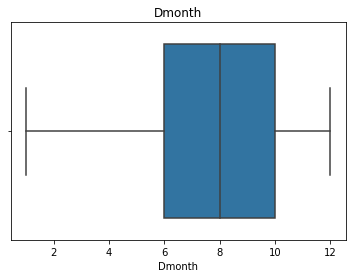

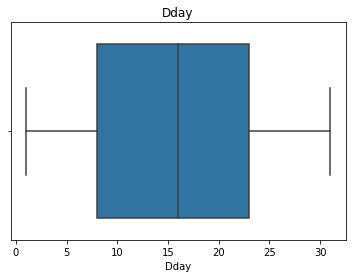

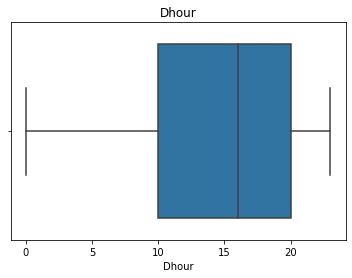

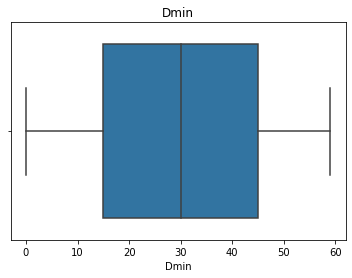

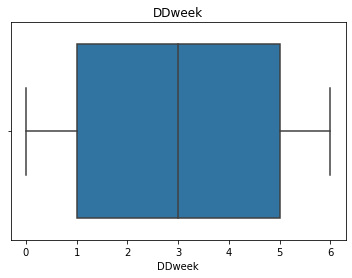

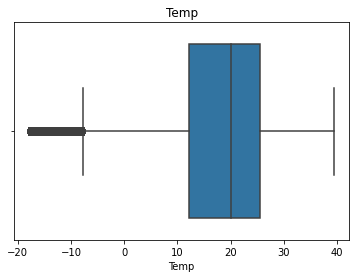

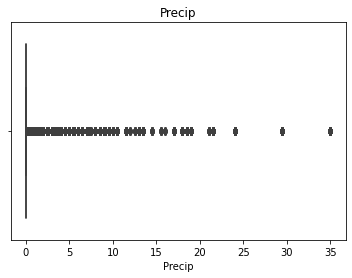

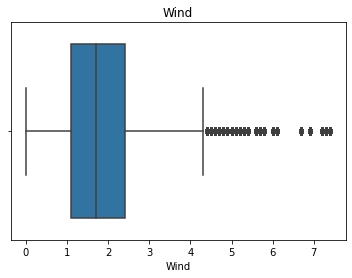

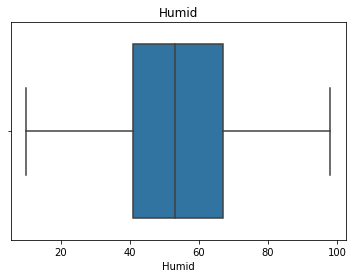

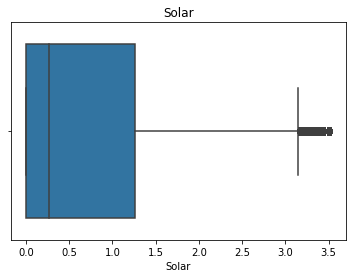

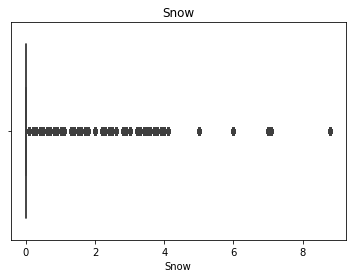

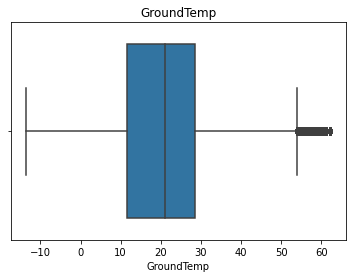

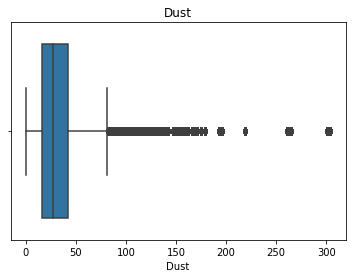

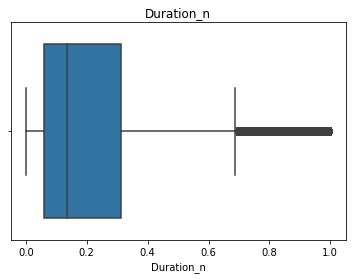

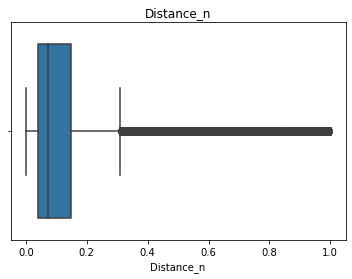

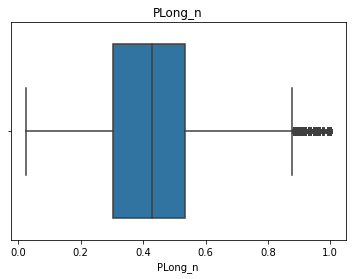

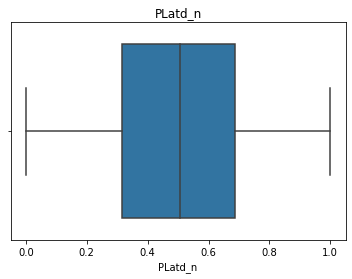

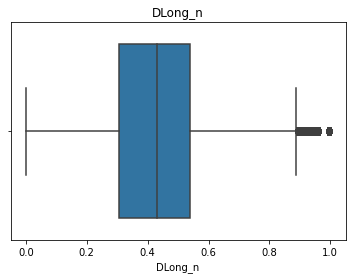

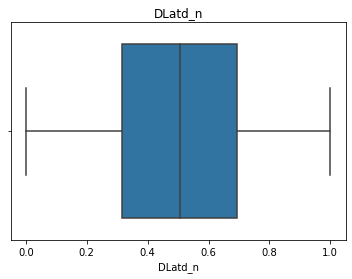

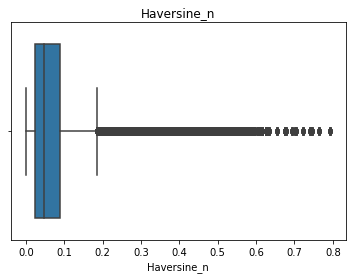

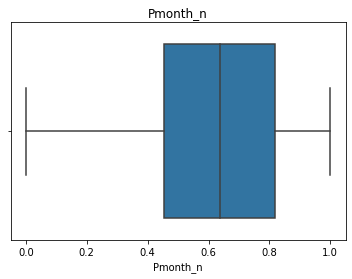

In [26]:
for col in df_2.columns:
    if col!="index":
        sns.boxplot(df_2[col].compute())
        plt.title(col)
        plt.show()

In [27]:
print(f"""FOR PRECIPITATION \

Normal values \
{round((df_2[df_2["Precip"]==0].shape[0]/df_2.shape[0]).compute(),3)},\
Outlier values \
{round((df_2[df_2["Precip"]!=0].shape[0]/df_2.shape[0]).compute(),3)}
""")

FOR PRECIPITATION 
Normal values 0.988,Outlier values 0.012



In [28]:
df.describe().compute()

,Duration,Distance,PLong,PLatd,DLong,DLatd,Haversine,Pmonth,Pday,Phour,...,Dmin,DDweek,Temp,Precip,Wind,Humid,Solar,Snow,GroundTemp,Dust
count,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,...,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06
mean,2.580294e+01,3.713519e+03,3.754761e+01,1.269908e+02,3.754770e+01,1.269907e+02,1.870315e+00,7.578754e+00,1.576714e+01,1.437801e+01,...,2.999278e+01,2.945771e+00,1.856201e+01,1.784856e-02,1.819274e+00,5.397565e+01,7.300679e-01,9.948924e-03,2.072376e+01,3.245798e+01
std,2.504333e+01,3.956611e+03,4.441376e-02,8.257065e-02,4.445305e-02,8.323726e-02,1.995361e+00,2.696797e+00,8.748012e+00,6.249244e+00,...,1.730960e+01,1.977624e+00,9.498075e+00,3.736282e-01,9.710258e-01,1.742159e+01,9.175004e-01,1.628091e-01,1.265221e+01,2.407264e+01
min,1.000000e+00,1.000000e+00,3.743727e+01,1.267986e+02,3.743727e+01,1.267986e+02,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,-1.780000e+01,0.000000e+00,0.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,-1.360000e+01,0.000000e+00
25%,1.000000e+01,1.400000e+03,3.752029e+01,1.269232e+02,3.752029e+01,1.269225e+02,7.028166e-01,6.000000e+00,1.100000e+01,1.200000e+01,...,1.500000e+01,2.000000e+00,1.350000e+01,0.000000e+00,1.300000e+00,4.600000e+01,0.000000e+00,0.000000e+00,1.510000e+01,2.100000e+01
50%,2.100000e+01,2.730000e+03,3.755114e+01,1.270025e+02,3.755041e+01,1.270025e+02,1.369997e+00,8.000000e+00,1.800000e+01,1.700000e+01,...,3.000000e+01,4.000000e+00,2.160000e+01,0.000000e+00,2.000000e+00,5.800000e+01,6.800000e-01,0.000000e+00,2.410000e+01,3.300000e+01
75%,4.600000e+01,5.650000e+03,3.757419e+01,1.270651e+02,3.757404e+01,1.270662e+02,2.636363e+00,1.000000e+01,2.600000e+01,2.000000e+01,...,4.600000e+01,5.000000e+00,2.710000e+01,0.000000e+00,3.100000e+00,7.900000e+01,1.890000e+00,0.000000e+00,3.150000e+01,6.000000e+01
max,1.190000e+02,3.329000e+04,3.768972e+01,1.271803e+02,3.768972e+01,1.271803e+02,2.863448e+01,1.200000e+01,3.100000e+01,2.300000e+01,...,5.900000e+01,6.000000e+00,3.940000e+01,3.500000e+01,7.400000e+00,9.800000e+01,3.520000e+00,8.800000e+00,6.220000e+01,3.040000e+02


Depending on Snow grouping the Durations.

In [29]:
df[["Duration","Snow"]].groupby("Snow").agg({"Duration":["min","mean","max"]}).compute().head()

Duration                
          min       mean  max
Snow                         
0.0         1  25.857817  119
0.1         1  11.918860  112
0.2         1  17.516765  119
0.3         1  15.106536  119
0.4         1  20.982491  119

Finding outliers and removing outliers

In [30]:
q1=df["Duration"].quantile(0.25)
q3=df["Duration"].quantile(0.75)
iqr=q3-q1
upper = q3+1.5*iqr
lower = q1-1.5*iqr

upper = upper.compute()
lower = lower.compute()

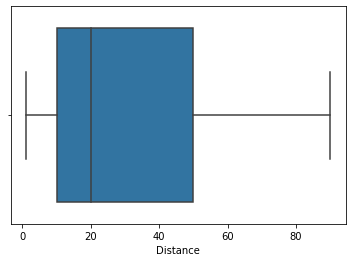

In [31]:
sns.boxplot(df[(df["Distance"]>lower) & (df["Distance"]<upper)]["Distance"])

In [32]:
outliers_removed = df[(df["Distance"]>lower) & (df["Distance"]<upper)][["Duration","Snow"]]

In [33]:
outliers_removed.groupby("Snow").agg({"Duration":["min","mean","max"]}).compute().head()

Duration               
          min      mean  max
Snow                        
0.0         1  9.150270  119
0.2         2  3.333333    5
0.3         1  4.500000   13
0.4         2  7.450000   77
0.5         2  4.222222    7

Means and medians, before outliers removed and after outliers removed

In [34]:
# With outliers.

arr = da.from_array(df["Duration"].compute().values,
                    chunks=(1000000,))
df["Duration"].mean().compute(),da.median(arr,axis=0).compute()

(25.80293723484266, 16.0)

In [35]:
# Without outliers.

arr = da.from_array(outliers_removed["Duration"].compute().values,
                    chunks=(1000000,))
outliers_removed["Duration"].mean().compute(),\
da.median(arr,axis=0).compute()

(9.139075151821862, 4.0)

Mean, standard deviation and correlation coefficients are sensitive to outliers!

In [36]:
selected_columns = ["Duration","Distance","Haversine","Temp",
                   "Precip","Wind","Humid","Solar","Snow",
                   "GroundTemp","Dust"]

Pearson correlation map. Only pearson can implemented with dask.

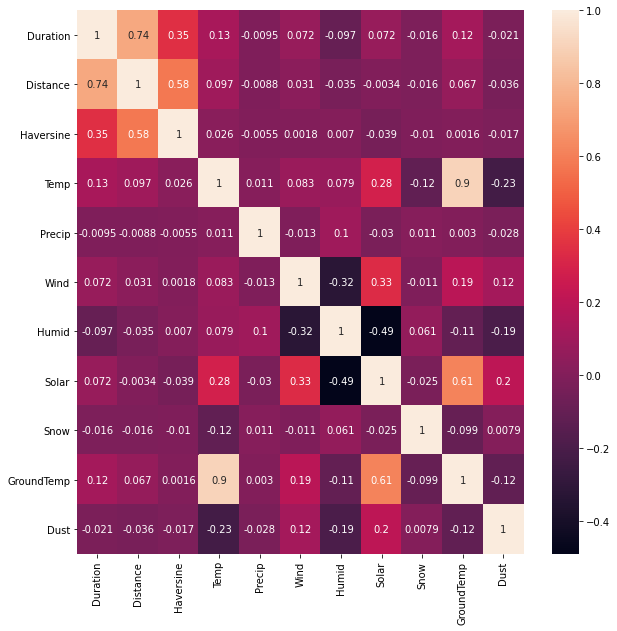

In [37]:
plt.figure(figsize=(10,10))
sns.heatmap(df[selected_columns].corr(method="pearson").compute(),
           annot=True)
plt.show()

To visualize scatter of large data.

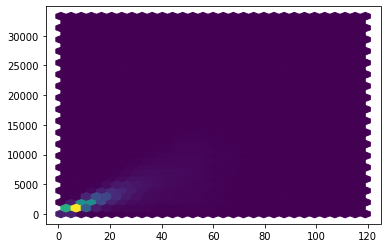

In [38]:
plt.hexbin(df["Duration"].compute(), df["Distance"].compute(),
          gridsize=30)
plt.show()

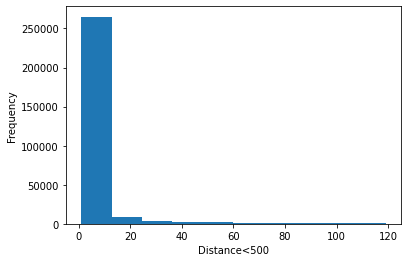

In [40]:
plt.hist(df[df.Distance<500]["Duration"].compute())
plt.xlabel("Distance<500")
plt.ylabel("Frequency")
plt.show()

___

## EXTRA

___

### DASK CLIENT (FUTURE)
Clustering and computing parallel except array and dataframe. With Python objects.

In [41]:
from dask.distributed import Client, progress, as_completed
import time 
import random

In [42]:
client = Client(threads_per_worker=4, n_workers=1)
client

Client Scheduler: tcp://127.0.0.1:40545 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 4 Memory: 25.07 GB


In [43]:
def inc(x):
    time.sleep(random.random())
    return x + 1

def double(x):
    time.sleep(random.random())
    return 2 * x

def add(x, y):
    time.sleep(random.random())
    return x + y

In [44]:
inc(1)

2

In [45]:
future = client.submit(inc, 1)
future

<Future: pending, key: inc-4e20f6fa5adfa828a0ed40153a7d620d>

In [46]:
future

<Future: finished, type: builtins.int, key: inc-4e20f6fa5adfa828a0ed40153a7d620d>

In [47]:
future.result()

2

In [48]:
%%timeit
x = client.submit(inc, 1)
y = client.submit(double, 2)
z = client.submit(add, x, y)
z.result()

6.1 ms ± 1.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [49]:
%%timeit
x = inc(1)
y = double(2)
z = add(x, y)

1.53 s ± 199 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
client.cluster.scale(5)

In [51]:
%time client.submit(inc, 1).result()

CPU times: user 6.29 ms, sys: 433 ms, total: 440 ms
Wall time: 245 ms


2

In [52]:
client.cluster.scale(10)

In [53]:
%time client.submit(inc, 1).result()

CPU times: user 3.17 ms, sys: 7.88 ms, total: 11 ms
Wall time: 8.94 ms


2

In [54]:
client.cluster.scale(20)

In [55]:
%time client.submit(inc, 1).result()

CPU times: user 12.3 ms, sys: 19.1 ms, total: 31.5 ms
Wall time: 31.2 ms


2

In [65]:
client.cluster.scale(1)

In [66]:
%%time
sum_arr = []
for i in range(10000):
    x = client.submit(inc, 1)
    sum_arr.append(x.result())
print(sum(sum_arr))

20000
CPU times: user 10.2 s, sys: 903 ms, total: 11.1 s
Wall time: 12.6 s


In [67]:
client.cluster.scale(10)

In [68]:
%%time
sum_arr = []
for i in range(10000):
    x = client.submit(inc, 1)
    sum_arr.append(x.result())
print(sum(sum_arr))

20000
CPU times: user 10.8 s, sys: 2.12 s, total: 13 s
Wall time: 14.2 s


In [64]:
%%time
sum_arr = []
for i in range(10):
    x = inc(1)
    sum_arr.append(x)
print(sum(sum_arr))

20
CPU times: user 1.09 s, sys: 162 ms, total: 1.25 s
Wall time: 5.67 s


If we want to see some of the computations' results and after that continue we need to use as_completed. Actually the process is you compute something until ac when you assign the processes to ac remain process is depend on me.

In [80]:
client.cluster.scale(20)

In [88]:
%%timeit
zs = []
for i in range(3000):
    x = inc(i)     # x = inc(i)
    y = double(x)  # y = inc(x)
    z = add(x, y)  # z = inc(y)
    zs.append(z)

293 ms ± 5.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [89]:
%%timeit
zs = []
for i in range(3000):
    x = client.submit(inc, i)     # x = inc(i)
    y = client.submit(double, x)  # y = inc(x)
    z = client.submit(add, x, y)  # z = inc(y)
    zs.append(z)

1.43 s ± 342 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [71]:
%%timeit
# With as_completed
finished_processes = []
x, y, z = client.map(inc, [1, 2, 3])
ac = as_completed([x, y, z])
for future in ac:
    finished_processes.append(future.result())

distributed.scheduler - ERROR - Couldn't gather keys {'inc-cee436b9ecd701b7d41b7569e6807cde': []} state: ['processing'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], inc-cee436b9ecd701b7d41b7569e6807cde
NoneType: None
distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {'inc-cee436b9ecd701b7d41b7569e6807cde': ()}
distributed.scheduler - ERROR - Couldn't gather keys {'inc-818c3f6a754a735df21a8f08799b2b5d': []} state: ['processing'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], inc-818c3f6a754a735df21a8f08799b2b5d
NoneType: None
distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {'inc-818c3f6a754a735df21a8f08799b2b5d': ()}


8.06 ms ± 3.2 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [72]:
%%timeit 
x, y, z = client.map(inc, [1, 2, 3])
finished_processes = []
for cl in [x, y, z]:
    finished_processes.append(cl.result())

The slowest run took 162.60 times longer than the fastest. This could mean that an intermediate result is being cached.
180 ms ± 279 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


___

### DASK DELAYED

I don't think delayed is useful. This is for parallelizing the functions.

In [73]:
import dask.delayed as delayed

In [74]:
def inc(x):
    return x + 1

def double(x):
    return x * 2

def add(x, y):
    return x + y

In [75]:
%%timeit

output = []
for x in range(1000):
    a = inc(x)
    b = double(x)
    c = add(a, b)
    output.append(c)

total = sum(output)

224 µs ± 1.34 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [76]:
@delayed
def inc(x):
    return x + 1

@delayed
def double(x):
    return x * 2

@delayed
def add(x, y):
    return x + y

In [77]:
%%timeit

output = []
for x in range(1000):
    a = inc(x)
    b = double(x)
    c = add(a, b)
    output.append(c)

total = delayed(sum)(output)

92.5 ms ± 371 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


___